# Customer Churn — Python + Pandas + Machine Learning
This notebook provides an end-to-end workflow: load data, clean & preprocess, exploratory data analysis (EDA), train Random Forest and Logistic Regression models, evaluate performance, and visualize key churn drivers.

In [1]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score, accuracy_score,
                             roc_curve, auc, confusion_matrix)

sns.set(style='whitegrid')
%matplotlib inline

In [2]:
# 2) Load data
train_path = r"c:\PYTHON\VS-CODE\project\GITHUB PROJECT\archive (1)\customer_churn_dataset-training-master.csv"
test_path = r"c:\PYTHON\VS-CODE\project\GITHUB PROJECT\archive (1)\customer_churn_dataset-testing-master.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print('train:', df_train.shape, 'test:', df_test.shape)

df = pd.concat([df_train, df_test], ignore_index=True)
print('combined:', df.shape)

# Quick peek
display(df.head())
df.info()

train: (440833, 12) test: (64374, 12)
combined: (505207, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB


In [3]:
# 3) Preprocessing (robust)
# Copy to avoid modifying originals
df = df.copy()

# Detect churn-like column names (case-insensitive, partial match)
churn_cols = [c for c in df.columns if 'churn' in c.lower()]
if churn_cols:
    original_churn_col = churn_cols[0]
    if original_churn_col != 'Churn':
        df.rename(columns={original_churn_col: 'Churn'}, inplace=True)
    print(f"Detected churn column: '{original_churn_col}' -> renamed to 'Churn'")
else:
    print('No churn-like column name detected (looked for "churn" in column names)')

# Inspect raw churn values before any mapping
if 'Churn' in df.columns:
    raw_vals = df['Churn'].dropna().unique()[:50]
    print('Sample unique values in raw Churn column (first 50):', raw_vals)

# Convert TotalCharges to numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Robust mapping of Churn to 0/1
if 'Churn' in df.columns:
    series = df['Churn']
    # If boolean or numeric 0/1
    if pd.api.types.is_bool_dtype(series) or pd.api.types.is_integer_dtype(series) or pd.api.types.is_float_dtype(series):
        df['Churn'] = pd.to_numeric(series, errors='coerce').round().astype('Int64')
    else:
        s = series.astype(str).str.strip().str.lower()
        # common text variants
        mapping = {'yes':1,'no':0,'y':1,'n':0,'true':1,'false':0,'1':1,'0':0}
        df['Churn'] = s.map(mapping)
        # try to coerce any remaining numeric-like strings
        if df['Churn'].isna().sum() > 0:
            coerced = pd.to_numeric(s, errors='coerce')
            df.loc[df['Churn'].isna(), 'Churn'] = coerced[df['Churn'].isna()]
    # final coercion to numeric with NaNs for unknowns
    df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')
    print('Churn value counts after robust mapping (including NaN):')
    print(df['Churn'].value_counts(dropna=False))
else:
    print('WARNING: No Churn column found after detection step')

# Drop ID-like columns
for col in ['customerID','CustomerID','customerId','id']:
    if col in df.columns and col != 'Churn':
        df.drop(columns=[col], inplace=True)
        break

# Fill logical missing TotalCharges
if set(['TotalCharges','MonthlyCharges','tenure']).issubset(df.columns):
    mask = df['TotalCharges'].isna()
    if mask.any():
        df.loc[mask, 'TotalCharges'] = (df.loc[mask, 'MonthlyCharges'] * df.loc[mask, 'tenure']).fillna(df['TotalCharges'].median())

# Identify and convert simple Yes/No object columns (excluding Churn)
for c in [c for c in df.select_dtypes(include='object').columns.tolist() if c != 'Churn']:
    vals = df[c].dropna().astype(str).str.strip().str.lower().unique()
    if set(vals).issubset({'yes','no','y','n','1','0','true','false'}):
        df[c] = df[c].astype(str).str.strip().str.lower().map({'yes':1,'no':0,'y':1,'n':0,'1':1,'0':0,'true':1,'false':0})

# One-hot encode remaining categorical object cols (exclude Churn)
cat_cols = [c for c in df.select_dtypes(include='object').columns.tolist() if c != 'Churn']
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Ensure numeric churn
if 'Churn' in df.columns:
    df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')

print('Preprocessed shape:', df.shape)

Detected churn column: 'Churn' -> renamed to 'Churn'
Sample unique values in raw Churn column (first 50): [1. 0.]
Churn value counts after robust mapping (including NaN):
Churn
1       280492
0       224714
<NA>         1
Name: count, dtype: Int64
Churn value counts after robust mapping (including NaN):
Churn
1       280492
0       224714
<NA>         1
Name: count, dtype: Int64
Preprocessed shape: (505207, 13)
Preprocessed shape: (505207, 13)


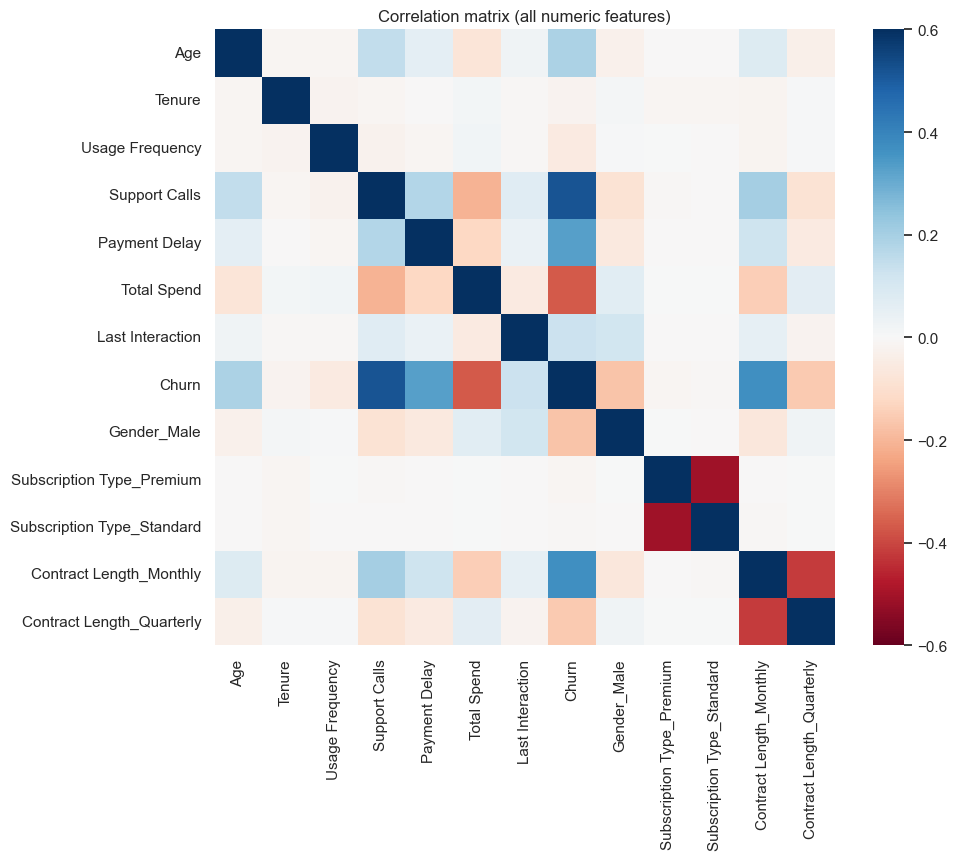

Overall churn rate: 55.52%


In [4]:
# 4) Quick EDA
# Correlation heatmap (subset to keep plot readable)
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='RdBu', center=0, vmax=0.6, vmin=-0.6)
plt.title('Correlation matrix (all numeric features)')
plt.show()

# Churn rate overall
if 'Churn' in df.columns:
    print('Overall churn rate: {:.2f}%'.format(df['Churn'].mean()*100))

# Tenure / MonthlyCharges influence if available
for col in ['tenure','MonthlyCharges','TotalCharges']:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df['Churn'].map({1:'Churn',0:'No Churn'}), y=df[col])
        plt.title(f'{col} by churn')
        plt.show()

In [5]:
# 5) Prepare data for modeling (robust split)
if 'Churn' not in df.columns:
    raise RuntimeError('Churn column not found. Check preprocessing outputs.')

# Drop rows with missing target and copy
df_model = df.dropna(subset=['Churn']).copy()
if df_model.shape[0] == 0:
    raise RuntimeError('No rows with non-missing Churn values after preprocessing')

# Feature matrix and target
X = df_model.drop(columns=['Churn'], errors='ignore')
# Ensure target is integer (0/1)
y = pd.to_numeric(df_model['Churn'], errors='coerce')
if y.isna().any():
    print('Warning: some Churn values could not be converted to numeric and will be dropped')
    mask = y.notna()
    X = X.loc[mask].copy()
    y = y.loc[mask].copy()

y = y.astype(int)

# Diagnostics
print('Total rows for modeling:', len(y))
print('Target class distribution:')
print(y.value_counts())

# Decide whether to stratify
test_size = 0.2
stratify_target = None
if y.nunique() < 2:
    raise RuntimeError('Target has only one class after preprocessing; cannot train a classifier.')

min_count = y.value_counts().min()
if min_count < 2:
    print('Warning: at least one class has fewer than 2 samples. Using non-stratified split.')
    stratify_target = None
else:
    # ensure at least one sample per class will be present in the test set when stratifying
    if ((y.value_counts() * test_size) < 1).any():
        print('Warning: test_size too small for stratified split for some classes. Using non-stratified split.')
        stratify_target = None
    else:
        stratify_target = y

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify_target, test_size=test_size, random_state=42)

# Show split diagnostics
print('After split:')
print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Train class distribution:')
print(y_train.value_counts())
print('Test class distribution:')
print(y_test.value_counts())

# Scale numeric features for Logistic Regression
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
if num_cols:
    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

Total rows for modeling: 505206
Target class distribution:
Churn
1    280492
0    224714
Name: count, dtype: int64
 505206
Target class distribution:
Churn
1    280492
0    224714
Name: count, dtype: int64
After split:
Train size: (404164, 12) Test size: (101042, 12)
Train class distribution:
Churn
1    224393
0    179771
Name: count, dtype: int64
Test class distribution:
Churn
1    56099
0    44943
Name: count, dtype: int64
After split:
Train size: (404164, 12) Test size: (101042, 12)
Train class distribution:
Churn
1    224393
0    179771
Name: count, dtype: int64
Test class distribution:
Churn
1    56099
0    44943
Name: count, dtype: int64


In [6]:
# 6) Fit models: Random Forest and Logistic Regression
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

# Metrics helper
def print_metrics(name, y_true, y_pred, y_proba):
    print(f"-- {name} --")
    print('Accuracy:', accuracy_score(y_true, y_pred))
    try:
        print('ROC AUC:', roc_auc_score(y_true, y_proba))
    except Exception as e:
        print('ROC AUC: could not compute', e)
    print(classification_report(y_true, y_pred))

print_metrics('Random Forest', y_test, y_pred_rf, y_proba_rf)
print_metrics('Logistic Regression', y_test, y_pred_lr, y_proba_lr)

-- Random Forest --
Accuracy: 0.9364521684052176
ROC AUC: 0.9535012214542444
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     44943
           1       0.90      1.00      0.95     56099

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.94      0.94    101042

-- Logistic Regression --
Accuracy: 0.843164228736565
ROC AUC: 0.9093755481305275
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     44943
           1       0.89      0.82      0.85     56099

    accuracy                           0.84    101042
   macro avg       0.84      0.85      0.84    101042
weighted avg       0.85      0.84      0.84    101042



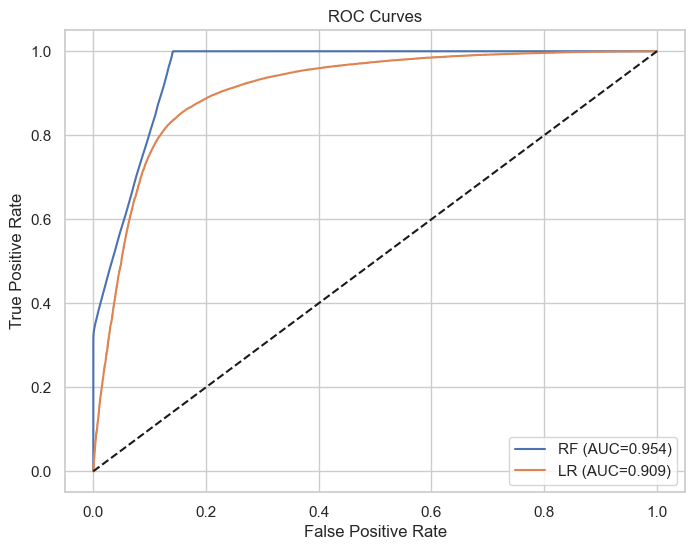

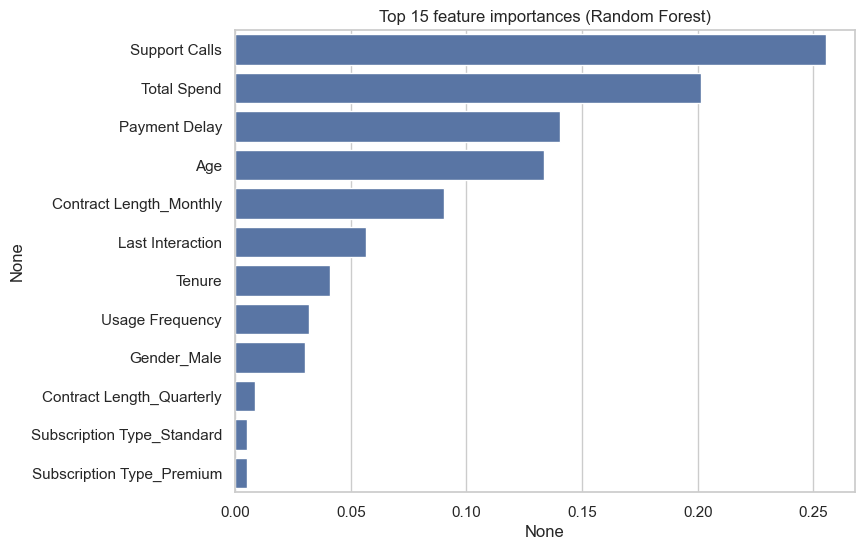

In [7]:
# 7) Plots: ROC curves and feature importances
plt.figure(figsize=(8,6))
for name, y_proba in (('RF', y_proba_rf), ('LR', y_proba_lr)):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Feature importances (Random Forest)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title('Top 15 feature importances (Random Forest)')
plt.show()

Next steps / tips
- Run cross-validation and GridSearchCV for hyperparameter tuning.
- Use SHAP for explainability if you want per-sample feature effects.
- Save the best model with joblib / pickle.
- If class imbalance is severe, try resampling (SMOTE) or calibrating thresholds.

In [8]:
# 8) Cross-validation and GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

print('Running GridSearchCV (this may take a while)')

# Random Forest grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Use StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

try:
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), rf_param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)
    print('Best RF params:', grid_rf.best_params_)
    best_rf = grid_rf.best_estimator_
except Exception as e:
    print('GridSearchCV for RF failed or skipped:', e)
    best_rf = rf  # fallback to previously trained rf

# Logistic Regression grid (use scaled data)
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2']
}
try:
    grid_lr = GridSearchCV(LogisticRegression(max_iter=2000, class_weight='balanced'), lr_param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
    grid_lr.fit(X_train_scaled, y_train)
    print('Best LR params:', grid_lr.best_params_)
    best_lr = grid_lr.best_estimator_
except Exception as e:
    print('GridSearchCV for LR failed or skipped:', e)
    best_lr = lr  # fallback

# Evaluate tuned models on test set
from sklearn.metrics import roc_auc_score

try:
    rf_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])
    print('Best RF ROC AUC on test:', rf_auc)
except Exception as e:
    print('Could not compute RF AUC:', e)

try:
    lr_auc = roc_auc_score(y_test, best_lr.predict_proba(X_test_scaled)[:,1])
    print('Best LR ROC AUC on test:', lr_auc)
except Exception as e:
    print('Could not compute LR AUC:', e)

Running GridSearchCV (this may take a while)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [9]:
# 9) Optional: handle class imbalance with SMOTE and retrain
try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    print('After SMOTE, class distribution:', np.bincount(y_res))
    # retrain a simple RF on resampled data
    rf_sm = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_sm.fit(X_res, y_res)
    try:
        print('RF (SMOTE) ROC AUC on test:', roc_auc_score(y_test, rf_sm.predict_proba(X_test)[:,1]))
    except Exception:
        pass
except Exception as e:
    print('imblearn.SMOTE not available or failed:', e)
    print('To install: pip install imbalanced-learn')

After SMOTE, class distribution: [224393 224393]
RF (SMOTE) ROC AUC on test: 0.9535814443237736
RF (SMOTE) ROC AUC on test: 0.9535814443237736


In [10]:
# 10) SHAP explainability (graceful fallback if SHAP not installed)
try:
    import shap
    shap.initjs()
    # sample background for speed
    sample_X = X_train.sample(n=min(200, len(X_train)), random_state=42)

    if hasattr(best_rf, 'predict_proba') and hasattr(shap, 'TreeExplainer'):
        explainer = shap.TreeExplainer(best_rf)
        shap_vals = explainer.shap_values(sample_X)
        # For binary classification TreeExplainer returns list-like
        try:
            shap.summary_plot(shap_vals[1], sample_X, show=False)
            plt.title('SHAP summary (RF)')
            plt.show()
        except Exception:
            pass

    # For Logistic Regression, use LinearExplainer if available
    if hasattr(best_lr, 'coef_') and hasattr(shap, 'LinearExplainer'):
        expl = shap.LinearExplainer(best_lr, X_train_scaled.sample(n=min(200, len(X_train_scaled)), random_state=42))
        shap_vals_lr = expl.shap_values(X_test_scaled.sample(n=min(200, len(X_test_scaled)), random_state=42))
        try:
            shap.summary_plot(shap_vals_lr, X_test_scaled.sample(n=min(200, len(X_test_scaled)), random_state=42), show=False)
            plt.title('SHAP summary (LR)')
            plt.show()
        except Exception:
            pass

except Exception as e:
    print('SHAP not available or error during SHAP explainability:', e)
    print('To install: pip install shap')

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP not available or error during SHAP explainability: name 'best_rf' is not defined
To install: pip install shap


In [12]:
# 11) Save best models to disk
import joblib

try:
    joblib.dump(best_rf, 'best_random_forest.joblib')
    print('Saved best RF to best_random_forest.joblib')
except Exception as e:
    print('Could not save best_rf:', e)

try:
    joblib.dump(best_lr, 'best_logistic_regression.joblib')
    print('Saved best LR to best_logistic_regression.joblib')
except Exception as e:
    print('Could not save best_lr:', e)

Could not save best_rf: name 'best_rf' is not defined
Could not save best_lr: name 'best_lr' is not defined


Notes
- GridSearchCV can be slow; reduce parameter options for quick runs.
- Install optional packages if needed: imbalanced-learn, shap.
- For reproducibility, save the preprocessing pipeline and feature list alongside models.